# Breast cancer data

## Preliminaries

### Import some basic modules

In [1]:
from sklearn import datasets
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Read the data

In [2]:
dat = datasets.load_breast_cancer()

### Get features $x$ and the target variable $y$

In [3]:
x = dat['data']
y = dat['target']
feature_names = dat['feature_names']

The target variable is boolean, it takes the value 1 for cancer cases, and the value 0 for non-cancer cases. We solve the binary classification problem.

### Convert the features $x$ into a dataframe, target variable into a series, for convenience.

In [4]:
df = pd.DataFrame(x, columns=feature_names)
ys = pd.Series(y)

### Classes balance

Classes percentage: 37.26%, 62.74%


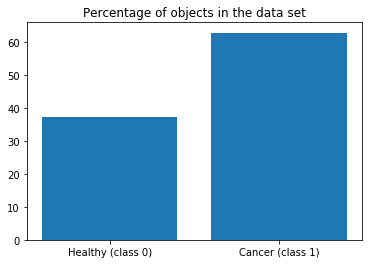

In [46]:
vc = ys.value_counts()
vc = vc / sum(vc) * 100
vcs = ['{0:6.2f}%'.format(vc[i]).strip() for i in range(len(vc))]
print('Classes percentage: {0}, {1}'.format(vcs[0], vcs[1]))
figsize(6,4)
cl_names = ['Healthy (class 0)', 'Cancer (class 1)']
vcso = vc.sort_index()
bar(vcso.index,vcso)
xticks(vcso.index, cl_names)
ti = title('Percentage of objects in the data set')

The problem is well balanced, there's no sugnificant prevalence of any class.

### Normalize all features by transforming to [0,1]

In [6]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
cl = df.columns
mms.fit(df)
dft = pd.DataFrame(mms.transform(df), columns=cl)

## Models validation

### Prepare cross-validation function

In [7]:
from sklearn.model_selection import KFold
def check_model(md, n_spl=3, x=np.array(dft), tit='Logistic regression'):
    kf = KFold(n_splits=n_spl)
    lst = list()
    for tr, te in kf.split(x):
        x_tr = x[tr, :]
        y_tr = y[tr]
        x_te = x[te, :]
        y_te = y[te]
        md.fit(x_tr, y_tr)
        y_pr = md.predict(x_te)
        sc = md.score(x_te, y_te)
        lst.append(sc)
    out = '{0:6.3f}'.format(np.array(lst).mean()).strip()
    print('{0}: mean models score {1}'.format(tit, out))

### Linear models

#### Import models

In [8]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

#### Test Logistic regression, SVM, Stochastic gradient descent for SVM, Random forest

In [49]:
check_model(LogisticRegression())
check_model(svm.SVC(), tit='SMV')
check_model(SGDClassifier(alpha=0.005), tit='Stochastic gradient descent')
check_model(RandomForestClassifier(n_estimators=20), tit='Random forest')

Logistic regression: mean models score 0.942
SMV: mean models score 0.937
Stochastic gradient descent: mean models score 0.918
Random forest: mean models score 0.954


Random forest model with 20 or 30 trees provides only a slightly better quality than linear models. Stochastic gradient descent would sometimes work better than logistic regression, yet sometimes worse. Thus simple logistic regression is the best choice among the models tested.

## Auxiliaries

### Feature historams

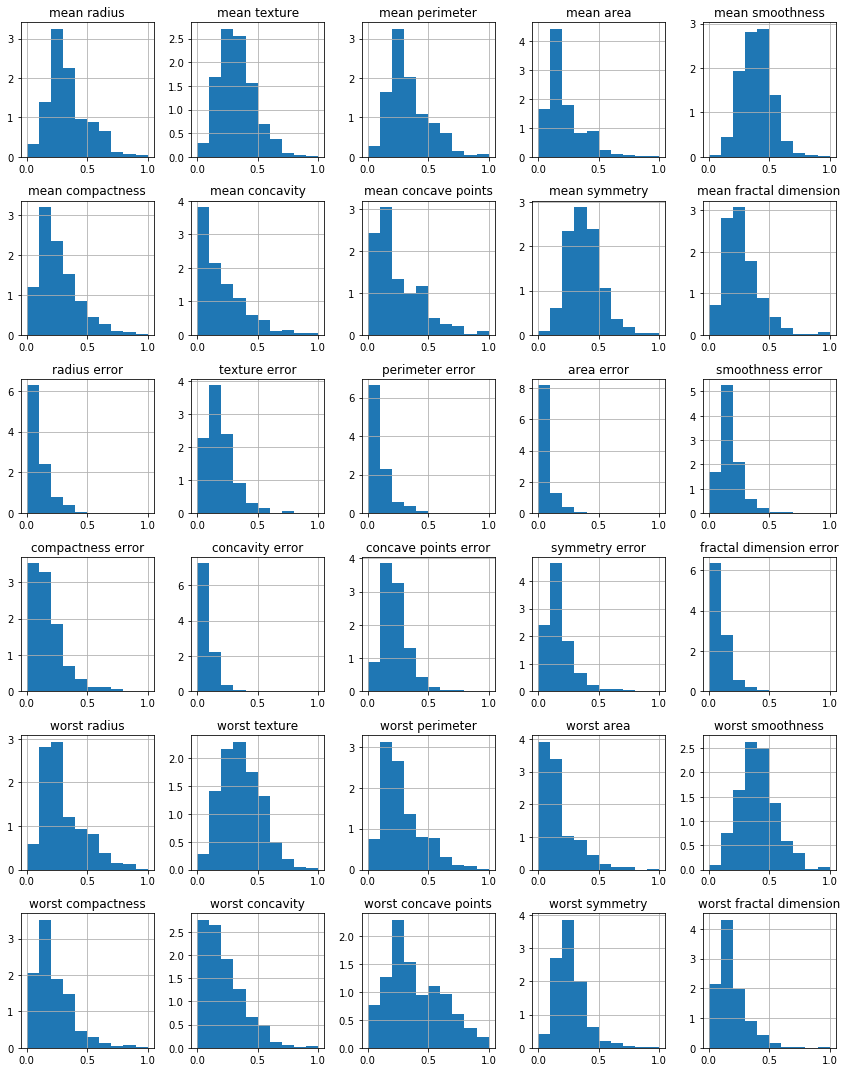

In [14]:
def features_hist():
    """ """
    n = len(feature_names)
    figsize(12, 15)
    for i in range(n):
        subplot(6, 5, i + 1)
        dft[feature_names[i]].hist(normed=True)
        title(feature_names[i])
    tight_layout()
features_hist()

### Tail conditional probabilities

Define functions for chars construction

In [11]:
def cond_prob_in_sub(sam_x, sam_y):
    mi = sam_x.min()
    ma = sam_x.max()
    n = 21
    xx = np.linspace(mi,ma,n)
    xxp = np.delete(xx,-1)
    lst = list()
    for xi in xxp:
        ind = (sam_x > xi)
        lst.append(sam_y[ind].mean())
    return xxp, np.array(lst)

def multiGraph(dft, ys, numb):
    cnt = 5
    rng = range(numb * cnt, (numb + 1) * cnt)
    for i in rng:
        xxp, lst = cond_prob_in_sub(dft[feature_names[i]], ys)
        plt.plot(xxp, lst, label=cl[i])
    plt.legend(ncol=1)

Build the charts of conditional probabilities $P\left(y=1|X>x\right)$ as functions of the current value $x\in[0,1]$ for a fixed feature $X$

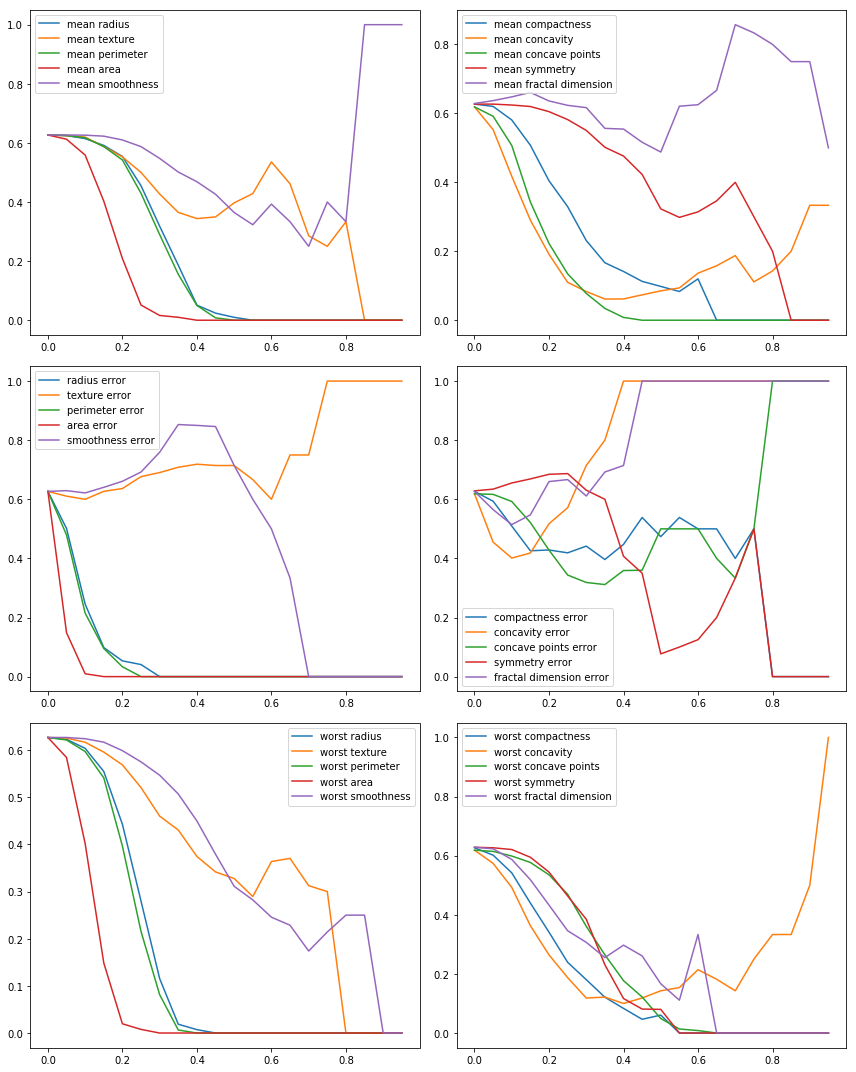

In [12]:
ys = pd.Series(y)
figsize(12,15)
for i in range(6):
    subplot(3, 2, i + 1)
    multiGraph(dft, ys, i)
tight_layout()

We see that conditions $X>x$ serve a good indicators of non-cancer cases $f(x)=P(y=1|X>x)$ for the features "mean area" ($f(x)=0$ for $x>0.4$), "area error" ($f(x)=0$ for $x>0.2$), and "worst area" ($f(x)=0$ for $x>0.3$). Here's why simple linear models manage to capture  separating surfaces of good quality.